In [74]:
from PIL import Image, ImageDraw
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import random

In [75]:
def drawBoundingRectangle(coordsTup , ImgObj, color='#ff0000', width=5, alpha=1.0):
    """
    Creates a box to highligt a location on the image object

    coordsTup = tuple of bbox corners. 
        top left coords = first 2 elements
        bottom right coords = last 2 elements
    width: width of outline
    color: hex value of color. Default red
    alpha: opacity. Range: 0,1
    """
    #Checking for transparency
    if alpha > 1 or alpha < 0: 
        alpha =1
    
    color_with_opacity = color + hex(int(alpha*255))[-2:]
    
    # Draw a rectangle
    draw = ImageDraw.Draw(ImgObj,'RGBA')
    
    p1_coord = coordsTup[0:2]
    p2_coord = coordsTup[2:4]
    draw.rectangle([p1_coord, p2_coord], outline=color_with_opacity, width=width)
    
    
def createNewPotentialBboxes(imgObj):
    img_width,  img_height = imgObj.size
    overlap = 0.4
    stride = 277*overlap 

    df_list = []
    for winsize in (277,277*2,277*3):
        if (winsize > img_width) or (winsize > img_height):
            break
        #if winsize odd, increase by 1 pixel. Just easier
        if (winsize % 2) != 0:
            winsize+=1
        xvals = np.arange((winsize/2), (img_width-winsize/2),stride)
        yvals = np.arange((winsize/2), (img_height-winsize/2),stride)
        list_centroids = [(x,y) for x in xvals for y in yvals]

        list_coordTuples = [get_bboxCoords(x_cnt,y_cnt,winsize) for x_cnt,y_cnt in list_centroids]

        #Appends new records for current winsize and bbox
        df_list.append(pd.DataFrame([list_coordTuples,[winsize]*len(list_coordTuples)]).T)

    df_bboxPotentials = pd.concat(df_list,ignore_index=True,axis=0)
    df_bboxPotentials.columns = ['bbox_bounds','winsize']
    df_bboxPotentials.to_csv(f'mass_maps/bboxPotentials_{img_width}_{img_height}.csv',index = False)
    return df_bboxPotentials

def get_bboxCoords(x_cnt,y_cnt,winsize):
    return int(x_cnt - winsize/2),int(y_cnt - winsize/2),int(x_cnt + winsize/2),int(y_cnt + winsize/2)

def getPotentialBboxes(imgObj,forceCreateNew = False):
    
    img_width,  img_height = imgObj.size
    
    if forceCreateNew:
        print('force creating new')
        df_bboxPotentials = createNewPotentialBboxes(imgObj)
    else:
        try:
            print('reading current')
            df_bboxPotentials = pd.read_csv(f'mass_maps/bboxPotentials_{img_width}_{img_height}.csv')
        except FileNotFoundError:
            print('no existing doc. creating')
            df_bboxPotentials = createNewPotentialBboxes(imgObj)
        
        
    return df_bboxPotentials

def getClassFromPred(pred,threshold):
    if max(pred)>threshold:
        return pred.argmax()
    return -1


def getRandomColor():
    #Shamelessly stolen from one of the references above
    #Returns a random hex color value
    return str(["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])][0])

In [76]:
im1 = Image.open('mass_maps/ESP_068561_1700_RED.NOMAP.browse.jpg')
img_width,  img_height = im1.size
print(im1.size)

(2048, 2836)


In [73]:
colorMap = {n:getRandomColor() for n in range(0,8)}
colorMap

{0: '#094539',
 1: '#852DB9',
 2: '#B56EF3',
 3: '#C076AA',
 4: '#56AEF8',
 5: '#D5F61A',
 6: '#74C7CF',
 7: '#792ECB'}

In [6]:
getPotentialBboxes(im1,forceCreateNew=True)

force creating new


,bbox_bounds,winsize
0,"(0, 0, 278, 278)",278
1,"(0, 110, 278, 388)",278
2,"(0, 221, 278, 499)",278
3,"(0, 332, 278, 610)",278
4,"(0, 443, 278, 721)",278
...,...,...
882,"(1107, 1551, 1939, 2383)",832
883,"(1107, 1661, 1939, 2493)",832
884,"(1107, 1772, 1939, 2604)",832
885,"(1107, 1883, 1939, 2715)",832


In [7]:
df_bbox = getPotentialBboxes(im1)
list_imagesToClassify = [im1.crop(eval(df_bbox.iloc[rowNum]['bbox_bounds'])) for rowNum in range(0,df_bbox.shape[0])]

reading current


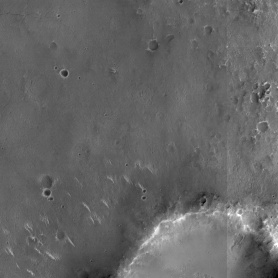

In [8]:
eg_img = list_imagesToClassify[0]
eg_img

In [9]:
final_model = tf.keras.models.load_model('tf_Adam_new_checkpoints/Model_final3/')

In [24]:
# Fresh start on sliced output folder
slicePath = f"{'/'.join(im1.filename.split('/')[:-1])}/_slices_{im1.filename.split('/')[-1]}/"
slicePath = slicePath.replace('.','_')
if (os.path.exists(slicePath) and os.path.isdir(slicePath)):
    shutil.rmtree(slicePath)
os.makedirs(slicePath)

for count, img in enumerate(list_imagesToClassify):
    img.save(''.join([slicePath,str(count),'_',(im1.filename.split('/')[-1])]))

In [27]:
# Normalizing data for 8 bit
predict_datagen = ImageDataGenerator(rescale=1./255)

print(slicePath)
predict_generator = predict_datagen.flow_from_directory(
    'mass_maps/',
    target_size = (227,227),
    batch_size=8,
    color_mode='grayscale',
    class_mode=None
)

mass_maps/_slices_ESP_068561_1700_RED_NOMAP_browse_jpg/
Found 887 images belonging to 1 classes.


In [30]:
preds = final_model.predict(predict_generator)

111/111 [==============================] - 2s 20ms/step


In [34]:
preds[0].argmax()

4

In [176]:
im1.filename

'mass_maps/ESP_068561_1700_RED.NOMAP.browse.jpg'

In [40]:
df_bbox['predClass'] = [getClassFromPred(pred,0.7) for pred in preds]

In [43]:
df_bbox[df_bbox.predClass>-1]

,bbox_bounds,winsize,predClass
1,"(0, 110, 278, 388)",278,4
2,"(0, 221, 278, 499)",278,4
3,"(0, 332, 278, 610)",278,4
4,"(0, 443, 278, 721)",278,3
5,"(0, 554, 278, 832)",278,4
...,...,...,...
880,"(1107, 1329, 1939, 2161)",832,4
881,"(1107, 1440, 1939, 2272)",832,4
882,"(1107, 1551, 1939, 2383)",832,4
883,"(1107, 1661, 1939, 2493)",832,4


In [57]:
mask_img = Image.new("RGBA", (img_width, img_height), (0, 0, 0, 0))
df_validBbox = df_bbox[df_bbox.predClass>-1][['bbox_bounds','predClass']]

In [58]:
df_validBbox

,bbox_bounds,predClass
1,"(0, 110, 278, 388)",4
2,"(0, 221, 278, 499)",4
3,"(0, 332, 278, 610)",4
4,"(0, 443, 278, 721)",3
5,"(0, 554, 278, 832)",4
...,...,...
880,"(1107, 1329, 1939, 2161)",4
881,"(1107, 1440, 1939, 2272)",4
882,"(1107, 1551, 1939, 2383)",4
883,"(1107, 1661, 1939, 2493)",4


In [71]:
for idx in range(0, df_validBbox.shape[0]):
    
    drawBoundingRectangle(eval(df_validBbox.iloc[idx]['bbox_bounds']),
                          mask_img,
                          color=colorMap[df_validBbox.iloc[idx]['predClass']]
                                         )

In [69]:
df_validBbox.iloc[0]['bbox_bounds']

'(0, 110, 278, 388)'

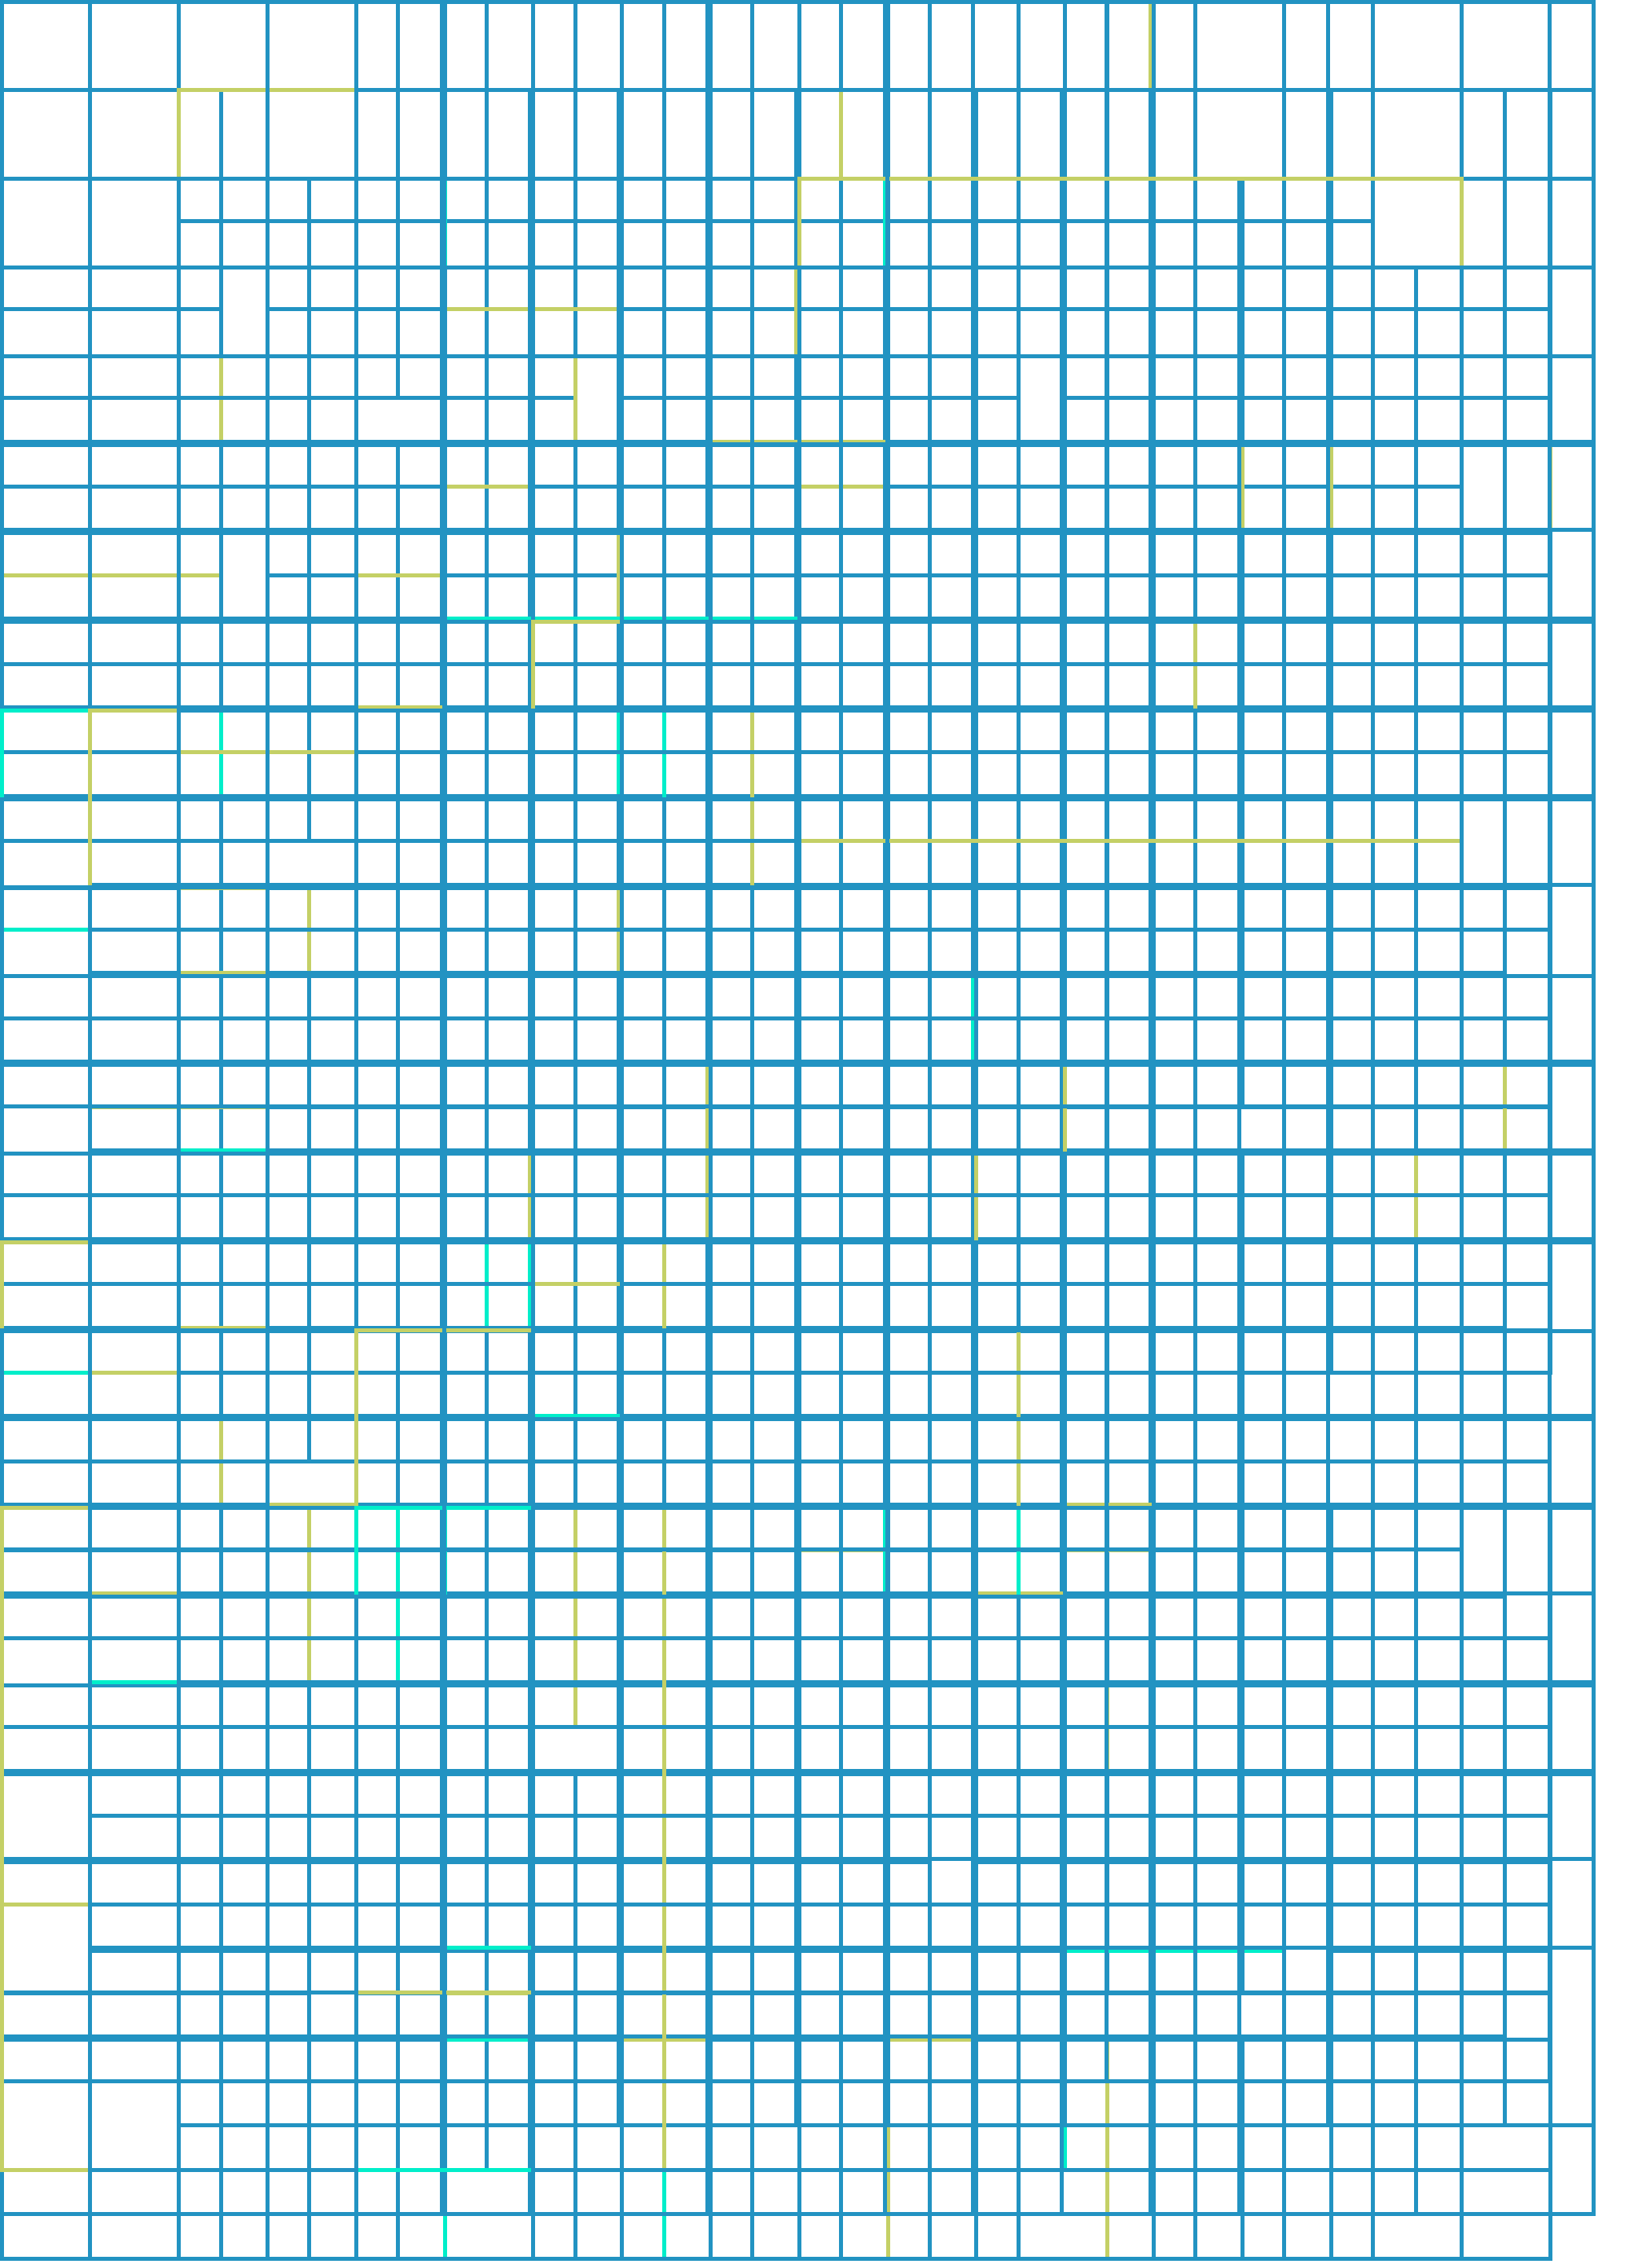

In [72]:
mask_img

In [207]:
# im2 = im1.convert('RGB')

# im2.paste(mask_img,(0,0),mask_img)
# im2